# **Vehicle Detection Project**

### The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Libraries

In [1]:
                 # File reading










## Read Images

In [2]:
import glob

vehicles = glob.glob('./train_images/vehicles/**/*.png')
non_vehicles = glob.glob('./train_images/non-vehicles/**/*.png')

print("Vehicle Images: {}".format(len(vehicles)))
print("Non-vehicle Images: {}".format(len(non_vehicles)))

Vehicle Images: 8792
Non-vehicle Images: 8968


## Visualize Images

In [3]:
import time
import numpy as np              # Matrix math
import cv2                      # OpenCV for image processing
import matplotlib.pyplot as plt # Data visualization library

# Show visualizations in notebook
%matplotlib inline                     

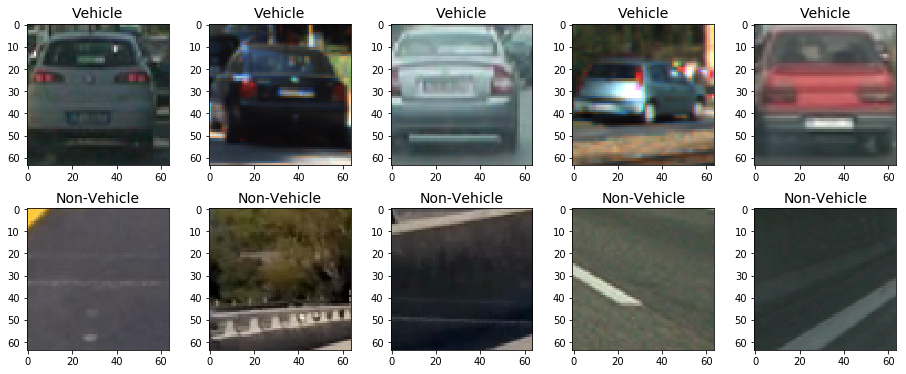

In [4]:
fig, axes = plt.subplots(2, 5, figsize=(16, 6))
fig.subplots_adjust(hspace =.3, wspace=.1)
axes = axes.ravel()

for i in range(5):
    img = cv2.imread(vehicles[np.random.randint(0, len(vehicles))])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].set_title('Vehicle', fontsize=14)
    axes[i].imshow(img)
    
    img = cv2.imread(non_vehicles[np.random.randint(0, len(non_vehicles))])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i + 5].set_title('Non-Vehicle', fontsize=14)
    axes[i + 5].imshow(img)


## HOG Feature Extraction

In [5]:
from skimage.feature import hog
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg

In [6]:
class HogParameters:
    def __init__(self):
        self.cspace = 'YCrCb'
        self.orient = 12
        self.pix_per_cell = 16
        self.cell_per_block = 2
        self.hog_channel = 'ALL'
        
hp = HogParameters()
print(hp.cspace)

YCrCb


In [7]:
def get_hog_features(img, orient=hp.orient, pix_per_cell=hp.pix_per_cell, cell_per_block=hp.cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

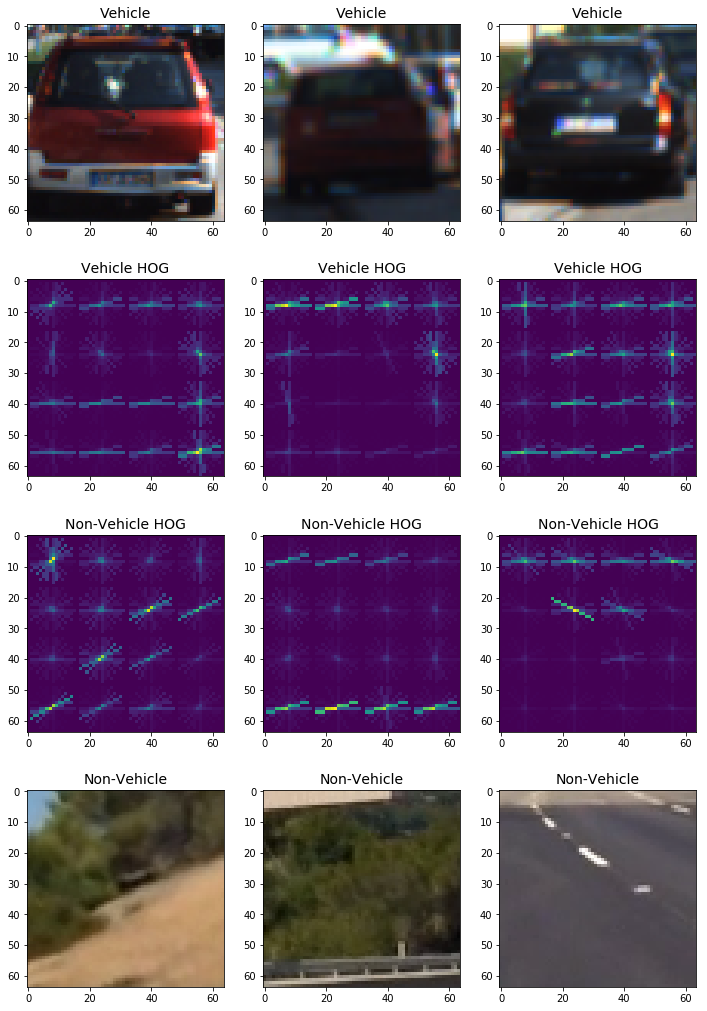

In [8]:
fig, axes = plt.subplots(4, 3, figsize=(12, 18))
axes = axes.ravel()


for i in range(3):
    veh_img = mpimg.imread(vehicles[np.random.randint(0, len(vehicles))])
    _, veh_dst = get_hog_features(veh_img[:,:,2], vis=True)
    axes[i].set_title('Vehicle', fontsize=14)
    axes[i].imshow(veh_img)
    
    axes[i + 3].set_title('Vehicle HOG', fontsize=14)
    axes[i + 3].imshow(veh_dst)
    
    non_veh_img = mpimg.imread(non_vehicles[np.random.randint(0, len(vehicles))])
    _, non_veh_dst = get_hog_features(non_veh_img[:,:,2], vis=True)
    
    axes[i + 6].set_title('Non-Vehicle HOG', fontsize=14)
    axes[i + 6].imshow(non_veh_dst)
    
    axes[i + 9].set_title('Non-Vehicle', fontsize=14)
    axes[i + 9].imshow(non_veh_img)



In [9]:
def extract_features(imgs, cspace=hp.cspace, orient=hp.orient, pix_per_cell=hp.pix_per_cell, 
                     cell_per_block=hp.cell_per_block, hog_channel=hp.hog_channel):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
       
        if cspace != 'RGB':
            conversion = "cv2.COLOR_RGB2" + cspace
            feature_image = cv2.cvtColor(image, eval(conversion))
        else: 
            feature_image = np.copy(image)             
        
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel]))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel])
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [10]:
t = time.time()
car_features = extract_features(vehicles)
notcar_features = extract_features(non_vehicles)
t2 = time.time()

print("Seconds to extract HOG features: {}.".format(round(t2 - t, 2)))

Seconds to extract HOG features: 101.27.


## Train Model

In [11]:
from sklearn.svm import LinearSVC  # Linear SVM model
from sklearn.model_selection import train_test_split # For creating train/validation sets

In [12]:
# Split up data into randomized training and test sets
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)  
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=101)

print("Feature vector length: {}".format(len(X_train[0])))

Feature vector length: 1296


In [13]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these', n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

2.38 Seconds to train SVC...
Test Accuracy of SVC =  0.9868
My SVC predicts:  [ 0.  0.  0.  0.  0.  1.  1.  0.  1.  0.]
For these 10 labels:  [ 0.  0.  0.  0.  0.  1.  1.  0.  1.  0.]
0.00336 Seconds to predict 10 labels with SVC


In [14]:
#8
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace=hp.cspace, hog_channel=hp.hog_channel, svc=svc, orient=hp.orient, 
              pix_per_cell=hp.pix_per_cell, cell_per_block=hp.cell_per_block, show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32) / 255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) + 1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell) + 1  #-1 
    nfeat_per_block = orient * cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, feature_vec=False)
        hog3 = get_hog_features(ch3, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
            
            pred_features = []
            pred_features.append(hog_features)
           
            test_prediction = svc.predict(hog_features.reshape(1, -1))
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                rectangles.append(((xbox_left, ytop_draw + ystart),(xbox_left + win_draw, ytop_draw + win_draw + ystart)))
                
    return rectangles
    

In [15]:
#9
test_img = mpimg.imread('./test_images/test5.jpg')

ystart = 380  #400
ystop = 660  #656
scale = 1.5

rectangles = find_cars(test_img, ystart, ystop, scale)

print(len(rectangles), 'rectangles found in image')

4 rectangles found in image


In [16]:
#10
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

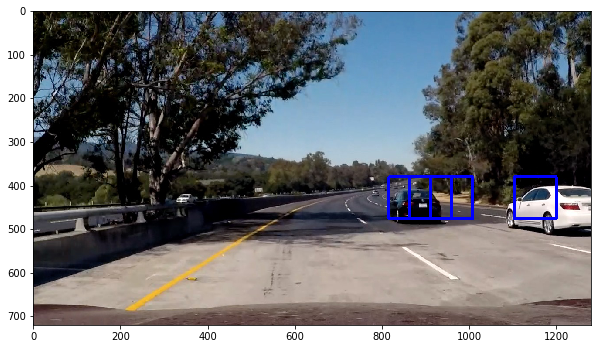

In [17]:
#11
test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10, 10))
plt.imshow(test_img_rects)

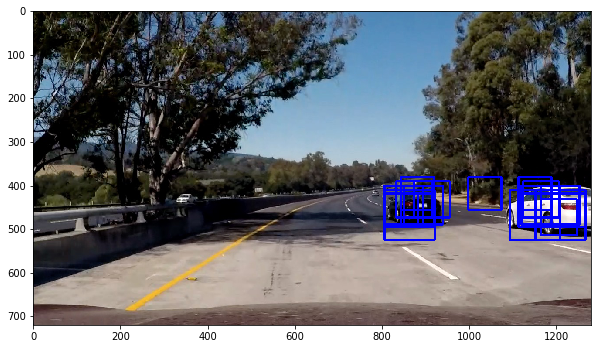

In [18]:
def get_rectangles(img):

    rectangles = []
    search_zones = [(380, 500, 1.2), 
                    (390, 550, 1.3),
                    (400, 600, 1.4),
                    (410, 625, 1.8),
                    (410, 660, 2.2),
                    (450, 660, 3.0)]
    
    for ystart, ystop, scale in search_zones:
        rectangles.append(find_cars(img, ystart, ystop, scale))
    
    rectangles = [item for sublist in rectangles for item in sublist] 
    
    return rectangles


test_img = mpimg.imread('./test_images/test5.jpg')
rectangles = get_rectangles(test_img)

test_img_rects = draw_boxes(test_img, rectangles, thick=3)

plt.figure(figsize=(10, 10))
plt.imshow(test_img_rects)

In [19]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

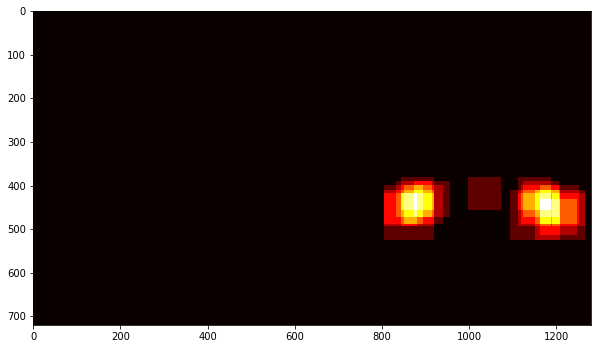

In [20]:
# Test out the heatmap
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')


In [21]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

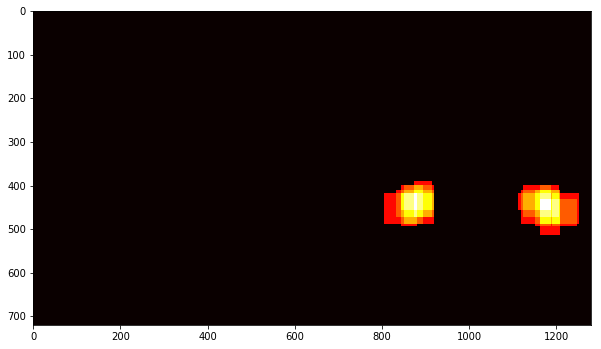

In [22]:
heatmap_img = apply_threshold(heatmap_img, 2)
plt.figure(figsize=(10, 10))
plt.imshow(heatmap_img, cmap='hot')

2 cars found


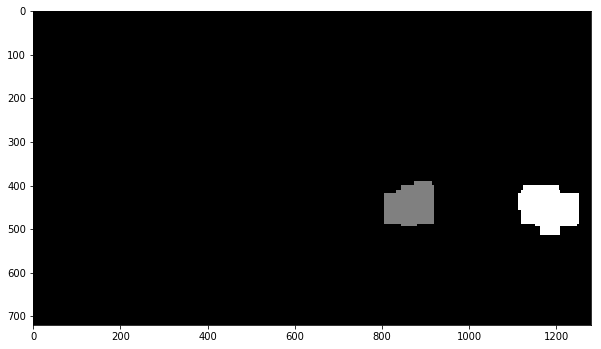

In [23]:
labels = label(heatmap_img)
plt.figure(figsize=(10, 10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

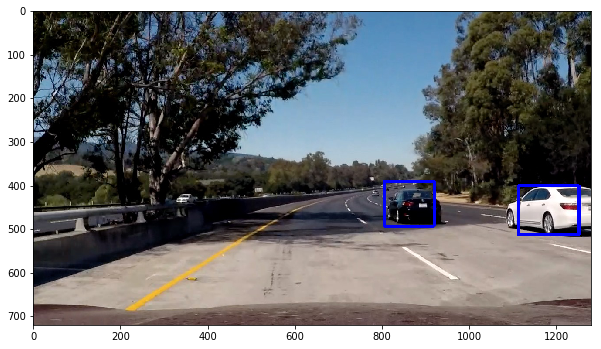

In [24]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)


In [25]:
def process_img(img):
    rectangles = get_rectangles(img)
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

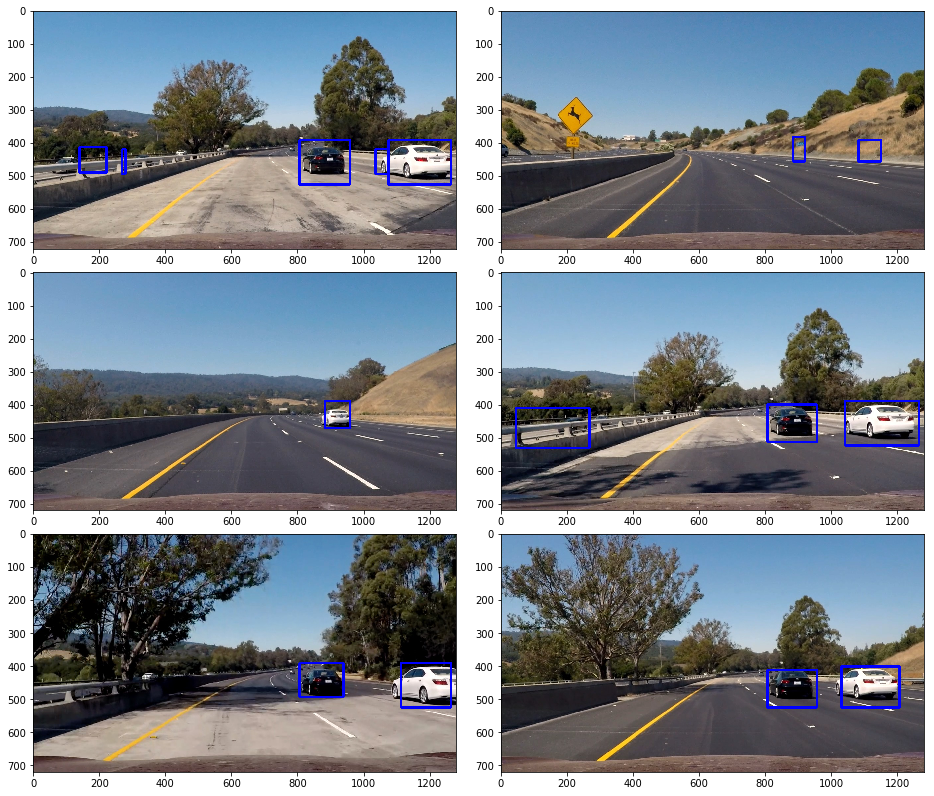

In [26]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axes = plt.subplots(3, 2, figsize=(16, 14))
fig.subplots_adjust(hspace = .1, wspace= .1)
axes = axes.ravel()

for i, im in enumerate(test_images):
    axes[i].imshow(process_img(mpimg.imread(im)))
    

In [27]:
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_img)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:31<00:00,  1.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 25.8 s, sys: 2.39 s, total: 28.2 s
Wall time: 35.1 s


In [28]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))

In [29]:
# Define a class to store data from video
class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 18:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[1:]


In [30]:
def process_video(img):
    rectangles = get_rectangles(img)
    # add detections to the history
    if len(rectangles) > 0:
        det.add_rects(rectangles)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    for rect_set in det.prev_rects:
        heatmap_img = add_heat(heatmap_img, rect_set)
    heatmap_img = apply_threshold(heatmap_img, 18)
     
    labels = label(heatmap_img)
    draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [234]:
rectangles = []

    colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 12
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    
    ystart = 380
    ystop = 500
    scale = 1.2
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    
    ystart = 390 #390
    ystop = 550 
    scale = 1.3
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    ystart = 400 #400
    ystop = 600 #600
    scale = 1.4
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    ystart = 410
    ystop = 625
    scale = 1.8
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
   
    ystart = 410
    ystop = 660
    scale = 2.2
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 450
    ystop = 660
    scale = 3.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))


    rectangles = [item for sublist in rectangles for item in sublist] 

In [31]:
det = Vehicle_Detect()

test_out_file2 = 'test_video_out_2.mp4'
clip_test2 = VideoFileClip('test_video.mp4')
clip_test_out2 = clip_test2.fl_image(process_video)
%time clip_test_out2.write_videofile(test_out_file2, audio=False)

[MoviePy] >>>> Building video test_video_out_2.mp4
[MoviePy] Writing video test_video_out_2.mp4


 97%|█████████▋| 38/39 [00:32<00:00,  1.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out_2.mp4 

CPU times: user 26.2 s, sys: 2.35 s, total: 28.5 s
Wall time: 36.8 s


In [32]:


HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file2))

In [33]:
det = Vehicle_Detect()

proj_out_file = 'project_video_out.mp4'
clip_proj = VideoFileClip('project_video.mp4') #.subclip(4, 10)  # subclip = only specified span of video
#clip_proj.save_frame('./test_images/project1.jpg', t=1.0) # saves the frame at time = t seconds
clip_proj_out = clip_proj.fl_image(process_video)
%time clip_proj_out.write_videofile(proj_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [20:59<00:00,  1.01it/s] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 14min 5s, sys: 1min 15s, total: 15min 20s
Wall time: 21min 3s


In [34]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(proj_out_file))